In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Transformers

## Introduction

Sequence to sequence models up to 2017:
- Recurrent Neural Network
- Long Short Term Memory
- Gated Recurrent Unit

<center><img src = "https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-rnn-ltr.png?9ea4417fc145b9346a3e288801dbdfdc" width = "60%"/></center>

Two main problems:
1. sequential input flow $\rightarrow$ slow training and prediction
2. many multiplications $\rightarrow$ exploding/vanishing gradients $\rightarrow$ loss of information + reduced window capacity

Transformers (Vaswani et al., 2017) are sequence2sequence encoder-decoder models mapping an input $x \in \mathbb{R}^x$ to an output $y \in \mathbb{R}^y$.\
They implement a mechanism called attention, which allows both parallelization ($\rightarrow$ faster training and prediction) and an infinitely large context window ($\rightarrow$ no more loss of information).

<center><img src="https://pytorch.org/tutorials/_images/transformer_architecture.jpg" width="30%"/></center>

## Transformers from scratch

The majority of the code is taken from https://github.com/ajhalthor/Transformer-Neural-Network .


In [1]:
max_sequence_len = 60 #number of tokens in each sentence
d_model = 6 #dimension of embeddings

### Input

<center><img src="https://github.com/Abudo-S/NLP_COURSE/blob/main/transformers/img/word_embedding_0.svg?raw=1" /></center>

#### Vocabularies lookup tables and Embeddings

In [3]:
START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

#loading vocabulary through spacy
import spacy
!python -m spacy download en_core_web_lg
!python -m spacy download it_core_news_lg
nlp_en = spacy.load('en_core_web_lg')
nlp_it = spacy.load('it_core_news_lg')
italian_vocab = [START_TOKEN, PADDING_TOKEN] + list(nlp_it.vocab.strings) + [END_TOKEN]
english_vocab = [START_TOKEN, PADDING_TOKEN] + list(nlp_en.vocab.strings) + [END_TOKEN]

#lookup tables
index_to_italian = {k:v for k,v in enumerate(italian_vocab)}
italian_to_index = {v:k for k,v in enumerate(italian_vocab)}
index_to_english = {k:v for k,v in enumerate(english_vocab)}
english_to_index = {v:k for k,v in enumerate(english_vocab)}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
italian_to_index['procioni'], english_to_index['racoons']

(559470, 618894)

From these vocabularies we can build $\texttt{nn.Embedding}$ layers, which behave as lookup tables. Indeed, they take as input an index and they retrieve the corresponging vector.\
The vector representation indicated the weighted matrix is initialized as random values and will be updated by backpropagation.\
We also specify the dimension for each embedding. In the original paper, $d_{model} = 512$; for simplicity, here is set to 6.

In [7]:
english_embedding = nn.Embedding(len(english_vocab), d_model)
italian_embedding = nn.Embedding(len(italian_vocab), d_model)

en_w, it_w = 660403, 559485
print(f"Embedding for the word {index_to_english[en_w]}: {english_embedding(torch.tensor(en_w))}")
print(f"Embedding for the word {index_to_italian[it_w]}: {italian_embedding(torch.tensor(it_w))}")


Embedding for the word subterranean: tensor([ 1.5526,  0.8724, -0.5266,  0.7325,  0.1742, -1.5248],
       grad_fn=<EmbeddingBackward0>)
Embedding for the word proclamasse: tensor([-1.1645,  0.6210,  0.6342, -0.5375, -0.2623, -0.8731],
       grad_fn=<EmbeddingBackward0>)


#### Data Preprocessing and Batching

dataset: https://www.statmt.org/europarl/

Next steps:
1. Preprocess each sentence by removing '\n', applying $\texttt{lower()}$
2. Filter those sentences which are too long and/or have unknown words
3. Take 10000 of those filtered sentences

In [8]:
#utility functions for checking sentence validity
def is_valid_tokens(sentence_tokenized, vocab):
    for token in sentence_tokenized:
        if isinstance(token, str):
            w = token
        else:
            w = token.text
        if w not in vocab:
            return False
    return True

def is_valid_length(sentence_tokenized, max_sequence_length):
    return len(sentence_tokenized) < (max_sequence_length)

def filter_and_preprocess(sent, tokenizer, vocab, max_s_len):
    tokenized = tokenizer(sent)
    if is_valid_length(tokenized, max_s_len) and is_valid_tokens(tokenized, vocab):
        return str(sent)
    return False

In [9]:
#taking only the first 10000 sentences meeting the requirements
MAX_SENTENCES = 10000

In [10]:
#use nltk word_tokenizer to speed up the process
from nltk.tokenize import word_tokenize

In [15]:
it_tokenizer = lambda text: word_tokenize(text, language='italian')
en_tokenizer = lambda text: word_tokenize(text, language='english')

import os

%cd /content/
!ls -R
repo_name = "NLP_COURSE"
#!rm -rf {repo_name}
if not os.path.exists(repo_name):
    print(f"Directory {repo_name} does not exist, proceeding with clone.")
    !git clone https://github.com/Abudo-S/NLP_COURSE.git

%cd NLP_COURSE

/content
.:
NLP_COURSE  sample_data

./NLP_COURSE:
BERT  data  imgs  lectures  nlp  projects  README.md  references  transformers

./NLP_COURSE/BERT:
bert-explained.ipynb  MLM.ipynb  transformers_multi_label_classification.ipynb
img		      NSP.ipynb

./NLP_COURSE/BERT/img:
 bert.drawio		   bert_models.png	  bert.svg
 bert_finetune.drawio	   bert.png		  bert_variants.png
 bert_finetune_mnli.svg    bert_pretrain_1.svg	 'encoder bw.png'
 bert_finetune_snli.svg    bert_pretrain_2.svg	  encoder.png
 bert_finetune_squad.svg   bert_pretrain.drawio   gpt.png

./NLP_COURSE/data:
biased-cv-doc.xlsx	 political-bias.ipynb
biased-cv-tab.xlsx	 README.md
europarl-v7.it-en.en	 recipes_w_search_terms.csv
europarl-v7.it-en.it.it  roman_number-classification.csv
food_recipes.csv	 roman_number-classification-test.csv
get-movie-data.ipynb	 roman_number-prediction.csv
get-recipes.ipynb	 roman_number-prediction-test.csv
moviedata.py		 weather.json

./NLP_COURSE/imgs:
clip.png	 image-acquisition.png	 raccoon.

## Dataset

The **European Parliament Proceedings Parallel Corpus 1996-2011** can be downloaded [here](https://www.statmt.org/europarl/)

In [16]:
english_file = "/content/NLP_COURSE/data/europarl-v7.it-en.en"
italian_file = "/content/NLP_COURSE/data/europarl-v7.it-en.it"

en_vocab = set(english_vocab)
it_vocab = set(italian_vocab)

#loading corpus for training
count = 0
english_lines, italian_lines = [], []
english_sentences, italian_sentences = [], []

print('Reading english sentences...')
with open(english_file,'rt') as f:
    english_lines = f.readlines()

print('Reading italian sentences...')
with open(italian_file,'rt') as f:
    italian_lines = f.readlines()

for (sentence_en, sentence_it) in zip(english_lines, italian_lines):
    if count < MAX_SENTENCES:
        preprocessed_sent_en = filter_and_preprocess(sentence_en.lower()[:-1],
                                                    en_tokenizer,
                                                    en_vocab,
                                                    max_sequence_len)
        if preprocessed_sent_en:
            preprocessed_sent_it = filter_and_preprocess(sentence_it.lower()[:-1],
                                                it_tokenizer,
                                                it_vocab,
                                                max_sequence_len)
            if preprocessed_sent_it:
                english_sentences.append(preprocessed_sent_en)
                italian_sentences.append(preprocessed_sent_it)
                count += 1
                print(count, end='\r')
    else: break

Reading english sentences...
Reading italian sentences...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
english_sentences[:2]

['resumption of the session',
 'i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.']

In [ ]:
italian_sentences[:2]

['ripresa della sessione',
 'dichiaro ripresa la sessione del parlamento europeo, interrotta venerdì 17 dicembre e rinnovo a tutti i miei migliori auguri nella speranza che abbiate trascorso delle buone vacanze.']

Next, we build a custom $\texttt{Dataset}$ class to store our input pairs and to obtain a nice interface for doing batching.

In [ ]:
#we build a dataset class for our specific MT task
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, italian_sentences):
        self.english_sentences = english_sentences
        self.italian_sentences = italian_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.italian_sentences[idx]

In [ ]:
#here is our dataset instance, which will work flawlessly with other pytorch modules
dataset = TextDataset(english_sentences, italian_sentences)

#saving the dataset
torch.save(dataset, '/content/NLP_COURSE/data/it-en_dataset.pt')

In [ ]:
dataset[34]

('agenda', 'ordine dei lavori')

In [ ]:
#loading dataset
dataset = torch.load('/content/NLP_COURSE/data/it-en_dataset.pt', weights_only=False)

Let's see how to batch our data: we simply create a $\texttt{DataLoader}$ instance to iterate through the dataset in batches of size 3.

In [ ]:
#we can also batch our data to make training faster
batch_size = 3
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)
batch = next(iterator)

In [ ]:
for i in range(batch_size):
    print(f"English: {batch[0][i]}")
    print(f"Italian: {batch[1][i]}\n\n")

English: resumption of the session
Italian: ripresa della sessione


English: i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Italian: dichiaro ripresa la sessione del parlamento europeo, interrotta venerdì 17 dicembre e rinnovo a tutti i miei migliori auguri nella speranza che abbiate trascorso delle buone vacanze.


English: please rise, then, for this minute' s silence.
Italian: vi invito pertanto ad alzarvi in piedi per osservare appunto un minuto di silenzio.




#### Tokenization

For this step, we replace each word with its corresponding index in the vocabulary lookup tables.\
Then, we add \<START\>, \<END\> and \<PADDING\> tokens accordingly.

In [ ]:
#now we build our tokenizer, using the previously-made lookup tables
def tokenize(sentence, language_to_index, lang_tokenizer, start_token=True, end_token=True):
    sentence_word_ids = [language_to_index[token.text] for token in lang_tokenizer(sentence)]
    if start_token:
        sentence_word_ids.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_ids.append(language_to_index[END_TOKEN])
    for _ in range(len(sentence_word_ids), max_sequence_len):
        sentence_word_ids.append(language_to_index[PADDING_TOKEN])
    return torch.tensor(sentence_word_ids)

In [ ]:
tokenize('my favourite animal is the raccoon.', english_to_index, nlp_en.tokenizer, start_token=False, end_token=True)

tensor([577301, 495208, 413600, 537346, 669662, 618747,   2090, 709120,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1])

In [ ]:
tokenize('il mio animale preferito è il procione.', italian_to_index, nlp_it.tokenizer, start_token=True, end_token=True)

tensor([     0, 452133, 508312, 307921, 556341, 677465, 452133, 559469,   3016,
        681818,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1])

In [ ]:
eng_tokenized, it_tokenized = [], []
for sentence_num in range(batch_size):
    eng_sentence, it_sentence = batch[0][sentence_num], batch[1][sentence_num]
    eng_tokenized.append(tokenize(eng_sentence, english_to_index, nlp_en.tokenizer, start_token=False, end_token=True))
    #start and end tokens are required for beginning and ending in the generation phase
    it_tokenized.append(tokenize(it_sentence, italian_to_index, nlp_it.tokenizer, start_token=True, end_token=True))

#concatenate array/tensor in a new dimension
eng_tokenized = torch.stack(eng_tokenized)
it_tokenized = torch.stack(it_tokenized)

In [ ]:
it_tokenized

tensor([[     0, 582908, 386186, 605987, 681818,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1],
        [     0, 390262, 582908, 479187, 605987, 385659, 538651, 412678,   1125,
         464560, 659102,  13442, 390158, 400625, 581836, 290096, 650346, 449621,
         506527, 506741, 320901, 520285, 620412, 356581, 291149, 645781, 386272,
         342072, 655725,   3016, 681818,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,   

#### Putting all together: fancy class for Sentence Embeddings

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, lang_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.language_tokenizer = lang_tokenizer
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token=True, end_token=True):

        def tokenize(sentence, start_token=True, end_token=True):
            sentence_word_ids = [self.language_to_index[token.text] for token in self.language_tokenizer(sentence)]
            if start_token:
                sentence_word_ids.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_ids.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_ids), self.max_sequence_length):
                sentence_word_ids.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_ids)

        tokenized = []
        for sentence_num in range(len(batch)):
            tokenized.append(tokenize(batch[sentence_num], start_token, end_token))
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device()) #set tensor to cuda "if available"

    def forward(self, x, start_token = True, end_token=True): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x) #map the tokenized sentences to the correspondent vector
        return x


In [ ]:
sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index,
                                    nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
english_batch = next(iterator)[0]
print(f"Input batch: {english_batch}\nOutput embeddings shapes:{[embedding.size() for embedding in sentence_embedding(english_batch, start_token = False, end_token = True)]}\nOuput embeddings: {sentence_embedding(english_batch)}")

Input batch: ("(the house rose and observed a minute' s silence)", "would it be appropriate for you, madam president, to write a letter to the sri lankan president expressing parliament's regret at his and the other violent deaths in sri lanka and urging her to do everything she possibly can to seek a peaceful reconciliation to a very difficult situation?", 'yes, mr evans, i feel an initiative of the type you have just suggested would be entirely appropriate.')
Output embeddings shapes:[torch.Size([60, 6]), torch.Size([60, 6]), torch.Size([60, 6])]
Ouput embeddings: tensor([[[-0.9587, -0.2663,  0.5240, -0.1451, -0.3856, -0.0566],
         [-1.3863, -0.1410, -0.6619,  0.5680, -0.5858, -1.7058],
         [ 1.1944,  0.3781,  0.1385, -0.4526, -0.9460,  0.0125],
         ...,
         [-1.8414,  0.1742,  0.0160,  0.6833,  0.8817, -1.4737],
         [-1.8414,  0.1742,  0.0160,  0.6833,  0.8817, -1.4737],
         [-1.8414,  0.1742,  0.0160,  0.6833,  0.8817, -1.4737]],

        [[-0.9587, -0

In [ ]:
next(iterator)[0]

('if the house agrees, i shall do as mr evans has suggested.',
 'madam president, on a point of order.',
 'that is precisely the time when you may, if you wish, raise this question, i.e. on thursday prior to the start of the presentation of the report.')

### Positional Encoding

The reason for using both sine and cosine functions is related to their complementary nature. Sine and cosine are fundamentally related through a phase shift. For any value x, we know that sin(x)=cos(x−π/2). This property is crucial for the model's ability to easily compute relative positions.

> Let's consider two positions, pos and pos + k. The model needs to be able to figure out that the distance between them is k, regardless of their absolute positions. The use of sine and cosine allows for this. By using simple trigonometric identities, the positional encoding for pos + k can be expressed as a linear function of the positional encoding for pos. This makes it easy for the self-attention mechanism to learn and model relative distances.






In [ ]:
#only for displaying purposes, we will lower
#max_sequence_len to 10
max_sequence_len = 10

$$
PE(\text{position}, 2i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$

$$
PE(\text{position}, 2i+1) = \cos\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$
where $i$ is the embedding dimension index, $position$ is the position of the word in the sentence, $d_{model}$ is the size of the embedding.
- sin and cos allow for constrained values
- sin and cos are periodic -> easier to attend to relative and distant positions


In [ ]:
torch.arange(0,d_model,2, dtype=torch.float).repeat_interleave(2)[:d_model]

tensor([0., 0., 2., 2., 4., 4.])

Note that, whenever position is an odd number $2i+1$, its respective cosine function still considers $2i$ in its denominator formula, which corresponds to $(2i+1)-1 = 2i$. For this reason, we use $\texttt{repeat\_interleave()}$ function to repeat even elements of the $i$ tensor.

In [ ]:
i = torch.arange(0,d_model,2, dtype=torch.float).repeat_interleave(2)[:d_model]
i

tensor([0., 0., 2., 2., 4., 4.])

The next code computes $10000^\frac{2i}{d_{model}}$.

In [ ]:
denominator = torch.pow(10000, 2*i/d_model)
denominator

tensor([1.0000e+00, 1.0000e+00, 4.6416e+02, 4.6416e+02, 2.1544e+05, 2.1544e+05])

This code computes $\text{position}$.


In [ ]:
torch.arange(max_sequence_len, dtype=torch.float).reshape(max_sequence_len, 1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
position = torch.arange(max_sequence_len, dtype=torch.float).reshape(max_sequence_len, 1)
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

And this code computes $\frac{ \text{position} }{10000^\frac{2i}{d_{model}}}$.

In [ ]:
sin_cos_argument = position/denominator
sin_cos_argument

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 2.1544e-03, 2.1544e-03, 4.6416e-06, 4.6416e-06],
        [2.0000e+00, 2.0000e+00, 4.3089e-03, 4.3089e-03, 9.2832e-06, 9.2832e-06],
        [3.0000e+00, 3.0000e+00, 6.4633e-03, 6.4633e-03, 1.3925e-05, 1.3925e-05],
        [4.0000e+00, 4.0000e+00, 8.6177e-03, 8.6177e-03, 1.8566e-05, 1.8566e-05],
        [5.0000e+00, 5.0000e+00, 1.0772e-02, 1.0772e-02, 2.3208e-05, 2.3208e-05],
        [6.0000e+00, 6.0000e+00, 1.2927e-02, 1.2927e-02, 2.7850e-05, 2.7850e-05],
        [7.0000e+00, 7.0000e+00, 1.5081e-02, 1.5081e-02, 3.2491e-05, 3.2491e-05],
        [8.0000e+00, 8.0000e+00, 1.7235e-02, 1.7235e-02, 3.7133e-05, 3.7133e-05],
        [9.0000e+00, 9.0000e+00, 1.9390e-02, 1.9390e-02, 4.1774e-05, 4.1774e-05]])

Now we are ready to apply the $\sin$ function to even vector positions ($\texttt{[:, 0::2]}$) and the $\cos$ function to odd vector positions ($\texttt{[:, 1::2]}$).\
This computation gives us the final positional encoding ($\texttt{PE}$).

In [ ]:
PE = torch.zeros(size = sin_cos_argument.shape)
#even positions
PE[:, 0::2] = torch.sin(sin_cos_argument[:, 0::2]) #starting from the 0 column with 2 column step
#odd positions
PE[:, 1::2] = torch.cos(sin_cos_argument[:, 1::2]) #starting from the 1 column with 2 column step
PE

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  2.1544e-03,  1.0000e+00,  4.6416e-06,
          1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  4.3089e-03,  9.9999e-01,  9.2832e-06,
          1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  6.4633e-03,  9.9998e-01,  1.3925e-05,
          1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  8.6176e-03,  9.9996e-01,  1.8566e-05,
          1.0000e+00],
        [-9.5892e-01,  2.8366e-01,  1.0772e-02,  9.9994e-01,  2.3208e-05,
          1.0000e+00],
        [-2.7942e-01,  9.6017e-01,  1.2926e-02,  9.9992e-01,  2.7850e-05,
          1.0000e+00],
        [ 6.5699e-01,  7.5390e-01,  1.5080e-02,  9.9989e-01,  3.2491e-05,
          1.0000e+00],
        [ 9.8936e-01, -1.4550e-01,  1.7235e-02,  9.9985e-01,  3.7133e-05,
          1.0000e+00],
        [ 4.1212e-01, -9.1113e-01,  1.9389e-02,  9.9981e-01,  4.1774e-05,
          1.0000e+00]])

In [ ]:
PE[3]

tensor([ 1.4112e-01, -9.8999e-01,  6.4633e-03,  9.9998e-01,  1.3925e-05,
         1.0000e+00])

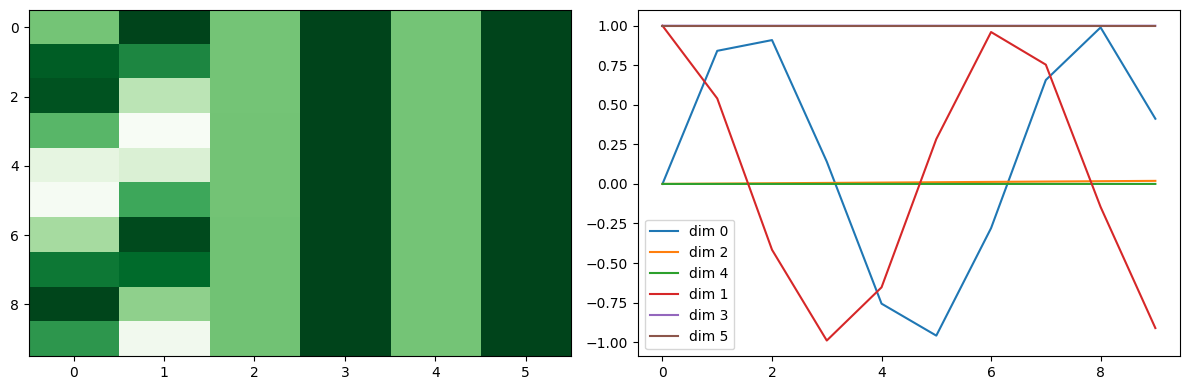

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(PE, aspect='auto', cmap='Greens')
for i in range(0, PE.shape[1], 2):
    ax[1].plot(PE[:, i], label=f"dim {i}")
for i in range(1, PE.shape[1], 2):
    ax[1].plot(PE[:, i], label=f"dim {i}")
ax[1].legend()
plt.tight_layout()
plt.show()

#### Fancy class for Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        i = torch.arange(0,self.d_model,2, dtype=torch.float).repeat_interleave(2)[:self.d_model]
        denominator = torch.pow(10000, 2*i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        sin_cos_argument = position/denominator
        PE = torch.zeros(size = sin_cos_argument.shape)
        PE[:, 0::2] = torch.sin(sin_cos_argument[:, 0::2]) #even positions
        PE[:, 1::2] = torch.cos(sin_cos_argument[:, 1::2]) #odd positions
        return PE

### Input Embeddings + Positional Encoding

Now we will update the $\texttt{SentenceEmbedding}$ class to output embeddings with encoded position.

In [ ]:
#resetting max_sequence_len
max_sequence_len = 60

In [ ]:
sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index, nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
english_batch = next(iterator)[0]
print(f"Input batch: {english_batch}\nOutput embeddings shapes:{[embedding.size() for embedding in sentence_embedding(english_batch, start_token = False, end_token = True)]}\nOuput embeddings: {sentence_embedding(english_batch)}")

Input batch: ('this is all in accordance with the principles that we have always upheld.', 'thank you, mr segni, i shall do so gladly.', 'indeed, it is quite in keeping with the positions this house has always adopted.')
Output embeddings shapes:[torch.Size([60, 6]), torch.Size([60, 6]), torch.Size([60, 6])]
Ouput embeddings: tensor([[[ 1.6509e+00,  2.0301e+00,  1.1240e+00,  1.0266e+00, -2.6553e+00,
           2.6204e-01],
         [ 1.9073e-01,  2.9417e+00,  1.3478e+00,  2.7260e+00,  5.7923e-01,
          -4.4876e-01],
         [ 2.8694e-01, -4.0435e-01, -1.2232e-01,  5.3399e-01, -6.4842e-01,
           0.0000e+00],
         ...,
         [ 3.2555e+00,  3.6284e+00,  3.1519e-01,  8.0926e-01,  6.4345e-01,
           7.1938e-02],
         [ 3.8741e+00,  2.7609e+00,  3.1757e-01,  8.0897e-01,  6.4346e-01,
           7.1938e-02],
         [ 0.0000e+00,  0.0000e+00,  3.1994e-01,  8.0867e-01,  0.0000e+00,
           7.1938e-02]],

        [[ 1.6509e+00,  2.0301e+00,  1.1240e+00,  1.0266e+00, 

In [ ]:
class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, lang_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.language_tokenizer = lang_tokenizer
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token=True, end_token=True):

        def tokenize(sentence, start_token=True, end_token=True):
            sentence_word_ids = [self.language_to_index[token.text] for token in self.language_tokenizer(sentence)]
            if start_token:
                sentence_word_ids.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_ids.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_ids), self.max_sequence_length):
                sentence_word_ids.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_ids)

        tokenized = []
        for sentence_num in range(len(batch)):
            tokenized.append(tokenize(batch[sentence_num], start_token, end_token))
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token = True, end_token=True): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        #applying dropout to the combined word and positional embeddings helps to make the embedding representations
        #more robust and less prone to overfitting on the training dataset.
        x = self.dropout(x + pos)
        return x


In [ ]:
en_sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index, nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
it_sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, italian_to_index, nlp_it.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)

In [ ]:
english_batch, italian_batch = next(iterator)

### Attention

#### Simple Attention

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/image2.png" width = "50%"/></center>

<center><img src="https://github.com/Abudo-S/NLP_COURSE/blob/main/transformers/img/attention.svg?raw=1"/></center>

Properties:
1. No access to "future" information $\rightarrow$ autoregressive generation
> The attention score matrix is a square matrix that shows the relationship between every token and every other token in the sequence.
Before applying the softmax function, a mask is applied. This mask is an upper triangular matrix with values of negative infinity (or a very large negative number) in the positions corresponding to future tokens.
When the softmax function is applied, these negative infinity values become zero, effectively setting the attention weights for future tokens to zero.

2. Each computation (Q, K, V per word) is independent $\rightarrow$ parallelization
> Transformers process all words in a sequence simultaneously rather than one at a time. The computations for each word's representation are done in parallel within the self-attention mechanism and the feed-forward network.

Steps:
1. Comparison (similarity)
$$
\text{score}(\mathbf{x_i}, \mathbf{x_j}) = \mathbf{x_i} \cdot \mathbf{x_j}, \quad \forall j \leq i
$$
2. Normalization
$$
\alpha_{ij} = \text{softmax}(\text{score}(\mathbf{x}_i, \mathbf{x}_j)) = \frac{exp(\text{score}(\mathbf{x}_i, \mathbf{x}_j))}{\sum_{k=1}^{i}exp(\text{score}(\mathbf{x}_i, \mathbf{x}_k))}, \quad \forall j \leq i
$$
3. Weighted sum
$$
\mathbf{y}_i = \sum_{j\leq i}\alpha_{ij}\mathbf{x}_j
$$

In [ ]:
np.set_printoptions(suppress=True) #set numpy printing in a fixed-point notation (ex. 1.23e-05 => 0.0000123)
x = torch.tensor(np.random.randint(1, 6, size=(4, 3)), dtype=float)
print(x, "\n")
print(x.T @ x, "\n")
print(torch.nn.functional.softmax(x.T @ x, dim=0).detach().numpy(), "\n")
print((torch.nn.functional.softmax(x.T @ x, dim=0) @ x.T).detach().numpy())

tensor([[3., 4., 3.],
        [5., 5., 1.],
        [2., 2., 3.],
        [3., 3., 4.]], dtype=torch.float64) 

tensor([[47., 50., 32.],
        [50., 54., 35.],
        [32., 35., 35.]], dtype=torch.float64) 

[[0.04742587 0.01798621 0.0242889 ]
 [0.95257411 0.98201378 0.48785555]
 [0.00000001 0.00000001 0.48785555]] 

[[ 0.28708915  0.35134931  0.20369086  0.29339184]
 [ 8.24934413 10.16079504  5.33274245  7.7551859 ]
 [ 1.46356672  0.48785565  1.46356669  1.95142226]]


#### Attention in transformers

Three different roles in attention process:
1. current focus of attention $\rightarrow$ **query**
2. input being compared $\rightarrow$ **key**
3. output for current focus $\rightarrow$ **value**
<center><img src="https://github.com/Abudo-S/NLP_COURSE/blob/main/transformers/img/query-key-value.svg?raw=1"/></center>

where
$$
\mathbf{Q} = \mathbf{XW}^Q, \quad \mathbf{K} = \mathbf{XW}^K, \quad \mathbf{V} = \mathbf{XW}^V; \quad \mathbf{Q}, \mathbf{K} \in \mathbb{R}^{N \times d_k}, \mathbf{V} \in \mathbb{R}^{N \times d_v}
$$
with $N$ being the number of input tokens and $d_k = d_v = d_{model}$ the dimensionality of input embeddings.

The three steps are the same, but with matrices (parallel computation):
1. Comparison
$$
\text{score}(\mathbf{Q}, \mathbf{K}) = \mathbf{Q}\mathbf{K}^\top
$$
2. Normalization (& scaling for stabilization)
$$
\text{Attention}(\mathbf{Q},\mathbf{K}) =\text{softmax}\left(\frac{\mathbf{QK^\top}}{\sqrt{d_k}}\right)
$$
3. Weighted sum
$$
\text{Output}= \text{softmax}\left(\frac{\mathbf{QK^\top}}{\sqrt{d_k}}\right)\mathbf{V}
$$

In [ ]:
d_k, d_v =  d_model, d_model
w_q = torch.randn(d_k, d_k)
w_k = torch.randn(d_k, d_k)
w_v = torch.randn(d_v, d_v)
input = en_sentence_embedding(english_batch, start_token = False, end_token = True)[0] #embeddings
tokenized_sentence = en_sentence_embedding.batch_tokenize(english_batch, start_token = False, end_token = True)[0] #textual representation of sentence, tokenized
tokenized_sentence_pad = [index_to_english[t.item()] for t in tokenized_sentence]
tokenized_sentence_nopad = [index_to_english[t.item()] for t in tokenized_sentence if t != english_to_index[PADDING_TOKEN]]
print(f"Query weight matrix shape:\t{w_q.size()}")
print(f"Key weight matrix shape:\t{w_k.size()}")
print(f"Value weight matrix shape:\t{w_v.size()}")
print(f"Input matrix shape:\t\t{input.size()}")

#computing Q, K and V
q = torch.matmul(input, w_q)
k = torch.matmul(input, w_k)
v = torch.matmul(input, w_v)
print(f"Query matrix shape:\t\t{q.size()}")
print(f"Key matrix shape:\t\t{k.size()}")
print(f"Value matrix shape:\t\t{v.size()}")

Query weight matrix shape:	torch.Size([6, 6])
Key weight matrix shape:	torch.Size([6, 6])
Value weight matrix shape:	torch.Size([6, 6])
Input matrix shape:		torch.Size([60, 6])
Query matrix shape:		torch.Size([60, 6])
Key matrix shape:		torch.Size([60, 6])
Value matrix shape:		torch.Size([60, 6])


In [ ]:
input_img, q_img, k_img, v_img = input[:len(tokenized_sentence_nopad),:] ,q[:len(tokenized_sentence_nopad),:], k[:len(tokenized_sentence_nopad),:], v[:len(tokenized_sentence_nopad),:]

In [ ]:
def softmax(x):
  return (torch.exp(x).T / torch.sum(torch.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v):
  d_k = q.shape[-1]
  scaled = torch.matmul(q, k.T) / math.sqrt(d_k)
  attention = softmax(scaled)
  output = torch.matmul(attention, v)
  return output, attention

In [ ]:
o, att = scaled_dot_product_attention(q, k, v)
print(f"Output shape:\t\t{o.size()}")
print(f"Attention shape:\t{att.size()}")

Output shape:		torch.Size([60, 6])
Attention shape:	torch.Size([60, 60])


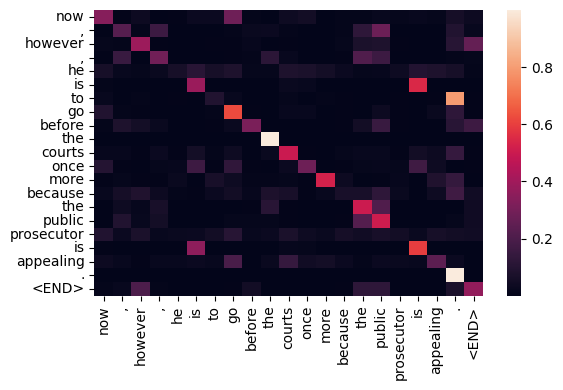

In [ ]:
o, att = scaled_dot_product_attention(input_img, input_img, v_img)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(att.detach().numpy(), xticklabels=tokenized_sentence_nopad, yticklabels=tokenized_sentence_nopad, ax=ax)
plt.tight_layout()
plt.show()

In [2]:
#quick visualization
!pip install bertviz
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

sentence_a = "John loves Mary"
sentence_b = "She is happy for that"
model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=4, head=3)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.4 MB/s eta 0:00:00


 59%|█████▉    | 259598336/440473133 [00:05<00:04, 43937951.30B/s]

KeyboardInterrupt: 

Attention in Transformers is used in three different ways:
- as the encoder's multi-head *self-attention*
> This is the core of the encoder. It's designed to help the encoder understand the relationships between all words in the input sequence. For each word, it calculates attention scores with every other word in the same sequence. This allows it to create a new, contextually rich representation for each word by weighing the importance of all the other words around it. Since the encoder processes the entire input at once, there's no need for masking.
- as the decoders' **masked** multi-head *self-attention*
> This mechanism serves a different purpose in the decoder. The decoder's goal is to generate an output sequence, one word at a time. To ensure the model doesn't "cheat" by looking at future words, this self-attention layer is masked. The mask sets the attention weights for future words to zero, ensuring that when the model is generating the word "bites" in the sentence "The dog bites the man," it can only pay attention to "The" and "dog," not "the" and "man" which follow.
- as the decoder's multi-head *cross-attention*
> This is the "encoder-decoder attention" layer. It allows the decoder to "look back" at the encoder's output and extract the most relevant information needed to generate the next word in the output sequence. The query comes from the decoder's masked self-attention output, while the key and value vectors come from the encoder's output. This cross-attention mechanism acts as a bridge between the encoder and decoder, giving the decoder a context vector tailored specifically to the word it's trying to generate.

Differences reside in the *masked* inputs and in source for $\mathbf{Q}, \mathbf{K}$ and $\mathbf{V} $. Let's see why and how.

##### Masking

By 'masking' we mean setting a value to $-\infty$. This leads to a 0-value output after the attention's softmax computation, which is exactly what we want.

In [ ]:
#to mask -> infinitely small number: needed when it will be passed
#through softmax and to avoid 0/0 errors
NEG_INFTY = -1e9

In [ ]:
english_batch[0]

'now, however, he is to go before the courts once more because the public prosecutor is appealing.'

In [ ]:
italian_batch[0]

'ora, però, verrà messo nuovamente in stato di accusa perché il pubblico ministero ricorrerà in appello.'

The encoder's multi-head self attention and decoder's multi-head cross attention does not need any mask. Indeed we want it to extract both right context and left context. The only mask we will apply will block attention to and from \<PADDING\> tokens.

In [ ]:
def create_encoder_padding_mask(eng_batch):
    masks = []
    tokenized_batch = en_sentence_embedding.batch_tokenize(eng_batch, start_token = False, end_token = True)
    for sentence in tokenized_batch:
        row = torch.where(sentence == en_sentence_embedding.language_to_index[en_sentence_embedding.PADDING_TOKEN],
                        True, False)
        mask = torch.tile(row.unsqueeze(0), (len(sentence), 1)) #repeats a tensor along specified dimensions.
        mask = torch.logical_or(mask, mask.T)
        mask = torch.where(mask, NEG_INFTY, 0)
        masks.append(mask)
    masks = torch.stack(masks)
    return masks.to(get_device())

In [ ]:
def create_decoder_padding_mask(eng_batch, it_batch):
    masks = []
    tokenized_it_batch = it_sentence_embedding.batch_tokenize(it_batch, start_token = True, end_token = True)
    tokenized_en_batch = en_sentence_embedding.batch_tokenize(eng_batch, start_token = False, end_token = True)
    masks = []
    for en_sentence, it_sentence in zip(tokenized_en_batch, tokenized_it_batch):
        en_row = torch.where(en_sentence == en_sentence_embedding.language_to_index[en_sentence_embedding.PADDING_TOKEN],
                        True, False)
        en_mask = torch.tile(en_row.unsqueeze(0), (len(en_sentence), 1))
        it_row = torch.where(it_sentence == it_sentence_embedding.language_to_index[it_sentence_embedding.PADDING_TOKEN],
                        True, False)
        it_mask = torch.tile(it_row.unsqueeze(0), (len(it_sentence), 1))
        mask = torch.logical_or(it_mask, en_mask.T)
        mask = torch.where(mask, NEG_INFTY, 0)
        masks.append(mask)
    masks = torch.stack(masks)
    return masks.to(get_device())

<Axes: >

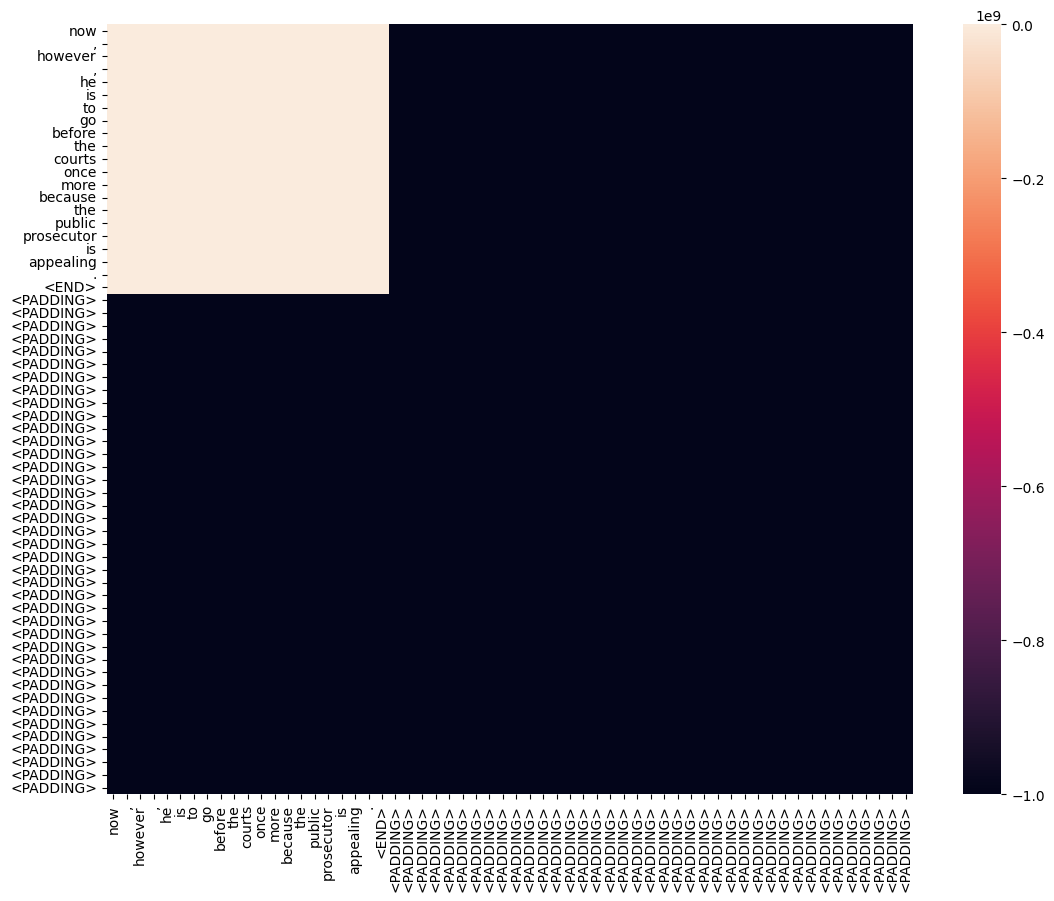

In [ ]:
m = create_encoder_padding_mask(english_batch)[0]
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(m, xticklabels=tokenized_sentence_pad, yticklabels=tokenized_sentence_pad)

Decoder's cross attention:

<Axes: >

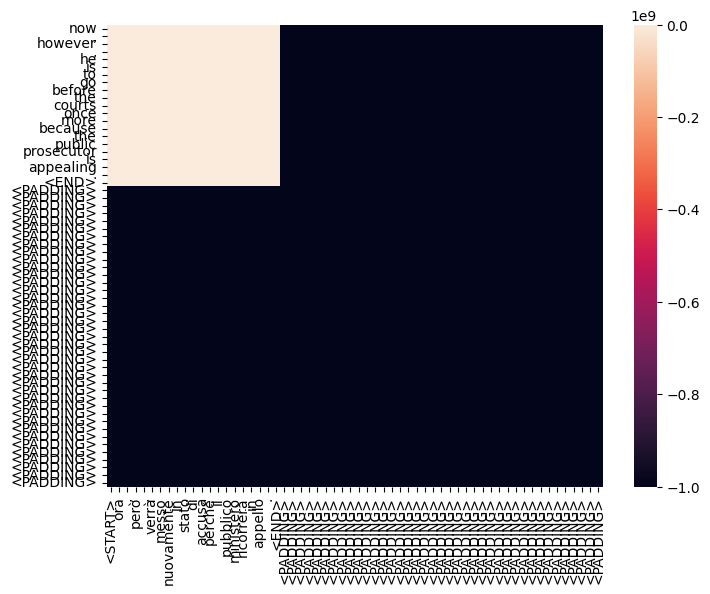

In [ ]:
tokenized_sentence_it = it_sentence_embedding.batch_tokenize(italian_batch, start_token = True, end_token = True)[0]
tokenized_sentence_it_pad = [index_to_italian[t.item()] for t in tokenized_sentence_it]
m = create_decoder_padding_mask(english_batch, italian_batch)[0]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(m, xticklabels=tokenized_sentence_it_pad, yticklabels=tokenized_sentence_pad)

The decoder's masked multi head self attention needs look-ahead masks because it needs to learn to predict the next token: not masking future inputs would be cheating. More formally, remember we need to retain the auto-regressive property of attention to be able to generate text.\
For the decoder's self attention we also need \<PADDING\> token mask.

In [ ]:
def create_decoder_masked_attention_mask(it_batch):
    tokenized_batch = it_sentence_embedding.batch_tokenize(it_batch, start_token = True, end_token = True)

    masks = []
    for sentence in tokenized_batch:
        #return a new tensor of a specified size filled with a single value
        look_ahead_mask = torch.full([len(sentence), len(sentence)] , True)
        #return a new tensor with all elements below the main diagonal set to zero
        look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
        row = torch.where(sentence == it_sentence_embedding.language_to_index[it_sentence_embedding.PADDING_TOKEN],
                        True, False)
        padding_mask = torch.tile(row.unsqueeze(0), (len(sentence), 1))
        padding_mask = torch.logical_or(padding_mask, padding_mask.T)
        mask = torch.logical_or(padding_mask, look_ahead_mask)
        mask = torch.where(mask, NEG_INFTY, 0)
        masks.append(mask)
    masks = torch.stack(masks)

    return masks.to(get_device())


<Axes: >

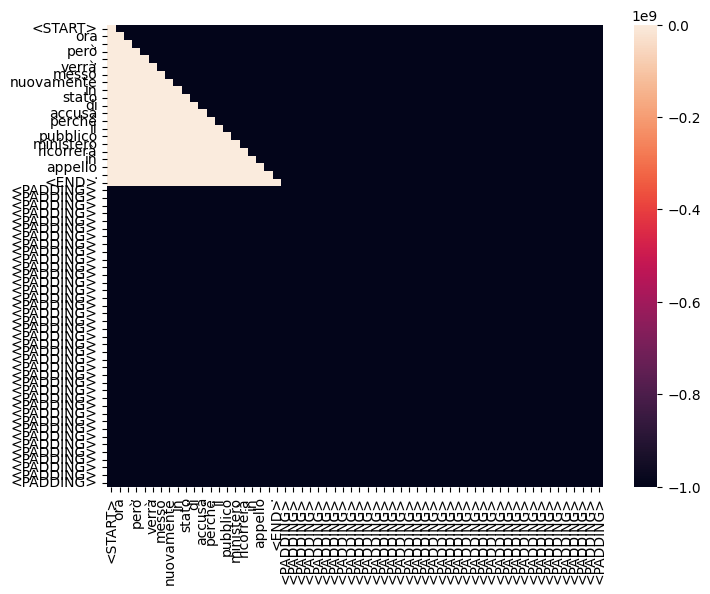

In [ ]:
m = create_decoder_masked_attention_mask(italian_batch)[0]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(m, xticklabels=tokenized_sentence_it_pad, yticklabels=tokenized_sentence_it_pad)

##### Final Attention Function

Let's redefine the attention function so that it accepts masks.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
  d_k = q.shape[-1]
  scaled = np.matmul(q, k.T) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = np.matmul(attention, v)
  return out, attention

### Multi-head Attention

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.\
They give enriched contextual representation: how do different words relate to each other simultaneously?\
These are sets of self-attention layers, called **heads**, that reside in parallel layers at the same depth in a model, each with its own set of parameters. Given these distinct set of parameters, each head can learn different aspects of the relationships that exist among inputs at the same level of abstraction.

Each head takes a split of the original $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ matrices. In the original paper, the authors employ $h = 8$ parallel attention layers, called **heads**, where each head has a reduced input embedding dimensionality $d_{model}/h = 64$, being $d_{model}=512$.\
For the $i$-th attention head,
$$
\mathbf{Q} = \mathbf{XW}_i^Q, \mathbf{K} = \mathbf{XW}_i^K, \mathbf{V} = \mathbf{XW}_i^V; \quad \mathbf{W}_i^Q \in \mathbb{R}^{d_{model}\times d_k}, \mathbf{W}_i^K \in \mathbb{R}^{d_{model}\times d_k}, \mathbf{W}_i^V \in \mathbb{R}^{d_{model}\times d_v}
$$
$$
\mathbf{head}_i = \text{SelfAttention}(\mathbf{Q}, \mathbf{K}, \mathbf{V})
$$
Then, we simply concatenate all $h$ outputs:
$$
\text{MultiHeadAttn}(\mathbf{X}) = (\mathbf{head}_1 \oplus \mathbf{head}_2, \dots, \oplus  \mathbf{head}_h) \mathbf{W}^O, \quad \mathbf{W}^O \in \mathbb{R}^{hd_{v}\times d_{model}}
$$

Let's say $h=4$: then
<center><img src="https://github.com/Abudo-S/NLP_COURSE/blob/main/transformers/img/multihead-attn.svg?raw=1" /></center>

In [ ]:
input = en_sentence_embedding(english_batch, start_token = False, end_token = True)
sequence_length = max_sequence_len
print(f"X shape: {input.size()}")

X shape: torch.Size([3, 60, 6])


We will stack our Q, K and V matrices in one single linear layer

In [ ]:
qkv_layer = nn.Linear(d_model , 3 * d_model)
qkv = qkv_layer(input)
print(f"QKV stacked matrix shape: {qkv.size()}")

QKV stacked matrix shape: torch.Size([3, 60, 18])


In [ ]:
num_heads = 2
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim) #split the last dimension in two, [num_heads and 3 * head_dim]
print(f"QKV stacked matrix shape after split data for {num_heads} heads: {qkv.size()}")

QKV stacked matrix shape after split data for 2 heads: torch.Size([3, 60, 2, 9])


Notice that this shape is equal to $\texttt{[batch\_size, sequence\_length, num\_heads, 3*head\_dim]}$.\
We want it to be $\texttt{[batch\_size, num\_heads, sequence\_length, 3*head\_dim]}$.

In [ ]:
#rearrange the dimensions
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
print(f"QKV stacked matrix shape after split data for {num_heads} heads, dimensions permuted: {qkv.size()}")

QKV stacked matrix shape after split data for 2 heads, dimensions permuted: torch.Size([3, 2, 60, 9])


Now we only have to (actually) split this matrix in 3 sub-matrices to compute attention.

In [ ]:
q, k, v = qkv.chunk(3, dim=-1) #breaking down last dimension
print(f"Q matrix from QKV stacked matrix: {q.size()}")
print(f"K matrix from QKV stacked matrix: {k.size()}")
print(f"V matrix from QKV stacked matrix: {v.size()}")

Q matrix from QKV stacked matrix: torch.Size([3, 2, 60, 3])
K matrix from QKV stacked matrix: torch.Size([3, 2, 60, 3])
V matrix from QKV stacked matrix: torch.Size([3, 2, 60, 3])


We are ready to compute attention. First, we must determine $d_k$.

In [ ]:
d_k = d_model // num_heads #equal to last dimension of q
d_k = q.size()[-1]

Notice that the matrix multiplication $\mathbf{QK}^\top$ must be coded such that only the last two dimensions of a vector with shape  $\texttt{[batch\_size, num\_heads, sequence\_length, 3*head\_dim]}$ must be transposed.

In [ ]:
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
print(f"Scaled QK matrix: {scaled.size()}")

Scaled QK matrix: torch.Size([3, 2, 60, 60])


Let's compute and apply the mask for this encoder self-attention.

In [ ]:
mask = create_encoder_padding_mask(english_batch)
mask = torch.tile(mask.unsqueeze(1), (1, num_heads, 1, 1)) #add a dummy dimension to replicate mask for each split
scaled = scaled + mask

Now that we have the masked scaled input, let's normalize the values through softmax.

In [ ]:
attention_weights = F.softmax(scaled, dim=-1) #computed only on last dimension containing scaled input
print(f"Attention weights matrix: {attention_weights.size()}")

Attention weights matrix: torch.Size([3, 2, 60, 60])


Let's compute the output of each head in multihead attention.

In [ ]:
heads_output = torch.matmul(attention_weights, v)
print(f"Output matrix for all heads: {heads_output.size()}")

Output matrix for all heads: torch.Size([3, 2, 60, 3])


The final output will simply be the reshaping of all heads outputs, averaged through a linear layer ($\mathbf{W}^O$).

In [ ]:
heads_output = heads_output.reshape(input.size())
print(f"Output matrix for all heads after reshaping, ready for averaging: {heads_output.size()}")

Output matrix for all heads after reshaping, ready for averaging: torch.Size([3, 60, 6])


In [ ]:
linear_layer = nn.Linear(d_model, d_model)
output = linear_layer(heads_output)
print(f"Final output matrix after averaging: {output.size()}")

#### Fancy class for Multi-head Attention

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out

In [ ]:
model = MultiheadAttention(d_model, num_heads)
out = model(input)
out

tensor([[[-0.1815, -0.6934, -0.1072, -0.0135,  0.5330, -0.0513],
         [-0.1970, -0.7488, -0.0271, -0.0108,  0.4686, -0.0932],
         [-0.1738, -0.6793, -0.1147, -0.0297,  0.5445, -0.0389],
         ...,
         [-0.1696, -0.6121,  0.1678, -0.0669,  0.4279, -0.0311],
         [-0.2199, -0.7326, -0.0500,  0.1187,  0.5358,  0.0296],
         [-0.1616, -0.6791, -0.0842,  0.0171,  0.6230,  0.1352]],

        [[-0.1198, -0.5155, -0.0268, -0.0665,  0.5410,  0.0180],
         [-0.0662, -0.6860,  0.0772,  0.0176,  0.5001,  0.0592],
         [-0.1649, -0.6740, -0.0255,  0.0337,  0.4997, -0.0401],
         ...,
         [-0.2406, -0.5456,  0.3990,  0.1319,  0.0904, -0.3986],
         [-0.2553, -0.6830,  0.1224,  0.2924,  0.2673, -0.2620],
         [-0.1012, -0.5264,  0.0952, -0.0017,  0.4880,  0.0404]],

        [[-0.2500, -0.8362, -0.0297,  0.0638,  0.4413, -0.1346],
         [-0.3346, -0.8322,  0.0011,  0.1660,  0.4168, -0.1419],
         [-0.2809, -0.7831, -0.1022,  0.0869,  0.4925, -0.

### Layer Normalization

Matrix multiplications can easily make matrix values exploding or vanishing.\
 Layer normalization helps with this possible problem, keeping the values in a range that facilitates gradient-based training.

Given a hidden layer with dimensionality $d_h$, these values are calculated as follows
$$
\mu = \frac{1}{d_h}\sum_{i = 1}^{d_h}x_i
$$
$$
\sigma = \sqrt{\frac{1}{d_h}\sum_{i = 1}^{d_h}(x_i - \mu)^2}
$$
and the normalized values will be computed as
$$
\hat{\mathbf{x}} = \frac{\mathbf{x}-\mu}{\sigma}
$$
Finally, in the standard implementation of layer normalization, two learnable parameters $\gamma$ and $\beta$, representing gain and offset values, are introduced
$$
\text{LayerNorm} = \gamma \hat{\mathbf{x}}+\beta
$$

We can compute the mean as

In [ ]:
#we average on the last two dimensions
mean = out.mean(dim = (-1, -2), keepdim=True) #keepdim=True retrieves a vector maintaining the number of dimensions of input
print(mean.size())
print(mean)

torch.Size([3, 1, 1])
tensor([[[-0.0717]],

        [[-0.0335]],

        [[-0.0805]]], grad_fn=<MeanBackward1>)


In [ ]:
#same for standard deviation
std = out.std(dim = (-1, -2), keepdim=True) #keepdim=True retrieves a vector maintaining the number of dimensions of input
print(std.size())
print(std)

torch.Size([3, 1, 1])
tensor([[[0.3683]],

        [[0.3233]],

        [[0.3737]]], grad_fn=<StdBackward0>)


And the normalized output is

In [ ]:
parameter_shape = out.size()[-2:]
print(parameter_shape)
gamma = nn.Parameter(torch.ones(parameter_shape))
beta =  nn.Parameter(torch.zeros(parameter_shape))

out_norm = (out - mean)/std
out_norm = gamma * out_norm + beta
print(out_norm.size())

torch.Size([60, 6])
torch.Size([3, 60, 6])


In [ ]:
print(f"Old mean and variance:\n{out.mean(dim = (-1, -2), keepdim=True)}\n{out.var(dim = (-1, -2), keepdim=True)}")
print()
print(f"New mean and variance:\n{out_norm.mean(dim = (-1, -2), keepdim=True)}\n{out_norm.var(dim = (-1, -2), keepdim=True)}")

Old mean and variance:
tensor([[[-0.0717]],

        [[-0.0335]],

        [[-0.0805]]], grad_fn=<MeanBackward1>)
tensor([[[0.1357]],

        [[0.1045]],

        [[0.1397]]], grad_fn=<VarBackward0>)

New mean and variance:
tensor([[[ 1.5895e-08]],

        [[-5.2982e-09]],

        [[-1.5895e-08]]], grad_fn=<MeanBackward1>)
tensor([[[1.0000]],

        [[1.0000]],

        [[1.0000]]], grad_fn=<VarBackward0>)


#### Fancy class for Layer Normalization

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, input):
        dims = (-1, -2)
        mean = input.mean(dim=dims, keepdim=True)
        var = ((input - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt() #adding espilon to avoid 0 values
        y = (input - mean) / std
        out = self.gamma * y + self.beta
        return out

In [ ]:
out.size()

torch.Size([3, 60, 6])

In [ ]:
layer_norm = LayerNormalization(out.size()[-2:])
output_norm = layer_norm(out)
output_norm

tensor([[[-0.2984, -1.6900, -0.0965,  0.1584,  1.6440,  0.0555],
         [-0.3405, -1.8407,  0.1214,  0.1658,  1.4690, -0.0584],
         [-0.2773, -1.6516, -0.1169,  0.1142,  1.6752,  0.0892],
         ...,
         [-0.2660, -1.4690,  0.6513,  0.0131,  1.3583,  0.1105],
         [-0.4028, -1.7965,  0.0590,  0.5176,  1.6515,  0.2756],
         [-0.2443, -1.6512, -0.0340,  0.2416,  1.8887,  0.5625]],

        [[-0.2671, -1.4929,  0.0208, -0.1020,  1.7797,  0.1597],
         [-0.1013, -2.0211,  0.3432,  0.1583,  1.6532,  0.2872],
         [-0.4070, -1.9840,  0.0250,  0.2083,  1.6518, -0.0203],
         ...,
         [-0.6413, -1.5862,  1.3397,  0.5126,  0.3838, -1.1309],
         [-0.6868, -2.0117,  0.4831,  1.0097,  0.9318, -0.7077],
         [-0.2097, -1.5266,  0.3987,  0.0985,  1.6156,  0.2289]],

        [[-0.4542, -2.0249,  0.1361,  0.3866,  1.3980, -0.1450],
         [-0.6810, -2.0141,  0.2186,  0.6605,  1.3324, -0.1646],
         [-0.5370, -1.8826, -0.0581,  0.4483,  1.5353, -0.

### Residual Connections

Residual connections are connections that pass information from a lower layer to a higher layer without going through the intermediate layer.
also known as skip connections, create a "shortcut" for the gradient. Instead of forcing the gradient to flow through every layer, it can take a direct path to earlier layers.

The process is:
- A sub-layer's input (x) is added directly to its output.
- The combined result is then passed through a Layer Normalization step.

They are essential to strengthen the signals in deep neural networks as gradients could vanish when performing a high number of matrix multiplications.

## Encoder

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask #swap batch and head dimensions to match dimensions with mask
        scaled = scaled.permute(1, 0, 2, 3) #resetting
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, input):
        dims = (-1, -2)
        mean = input.mean(dim=dims, keepdim=True)
        var = ((input - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt() #adding espilon to avoid 0 values
        y = (input - mean) / std
        out = self.gamma * y + self.beta
        return out


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        # make network understand better complex pattern
        x = self.relu(x)
        #better generalization
        x = self.dropout(x)
        #compress to 512 dimension
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x
        x = self.attention(x, mask= self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        #more layers for better vector representation for words and context
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                    for _ in range(num_layers)])

    def forward(self, x, self_attention_mask):
        x = self.layers(x, self_attention_mask)
        return x

In [ ]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048 #as in paper, helps with propagation of information
num_layers = 5 #multi to capture complexity

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [ ]:
en_sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, english_to_index, nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
english_batch = next(iterator)[0]
input = en_sentence_embedding(english_batch, start_token = False, end_token = True)
out_encoder = encoder(input, create_encoder_padding_mask(english_batch))
out_encoder

tensor([[[-0.8500,  0.7653,  2.1215,  ...,  1.4175,  1.3266,  0.2159],
         [-0.3447, -0.0237,  2.7391,  ...,  1.2201,  0.3153,  1.3035],
         [ 0.8989,  0.0924,  1.9214,  ...,  2.2226,  0.4726,  0.8035],
         ...,
         [-0.8846, -0.8238,  0.0117,  ...,  0.4396,  0.4311,  0.3909],
         [-1.7097, -1.3624,  0.1824,  ...,  0.0895,  0.1675,  0.1268],
         [-1.5144, -0.9629, -0.1346,  ..., -0.3034,  0.5814,  0.7248]],

        [[-0.4243, -0.4484,  0.8592,  ...,  1.2918,  0.8500,  1.7848],
         [ 0.2271, -0.9118,  2.3418,  ...,  1.6834,  0.2225,  2.1119],
         [-0.9242, -1.7416,  2.9309,  ...,  2.0814,  1.1473,  1.8689],
         ...,
         [-0.8875, -0.8801,  0.0251,  ...,  2.0645, -0.4778,  0.4431],
         [-1.1269, -0.8158,  0.0274,  ...,  2.5127, -0.3588,  0.6840],
         [-1.6378, -0.7345,  0.0125,  ...,  2.0877,  0.6633,  0.2867]],

        [[ 0.0536,  1.8209,  1.3162,  ...,  2.1728,  1.0742,  1.2236],
         [-0.2738,  0.4081,  0.0236,  ...,  0

## Decoder

In [ ]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y

In [ ]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

it_sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, italian_to_index, nlp_it.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
italian_batch = next(iterator)[1]
input_it = it_sentence_embedding(italian_batch, start_token = True, end_token = True)
self_attention_decoder_mask = create_decoder_masked_attention_mask(italian_batch)
cross_attention_mask = create_decoder_padding_mask(english_batch, italian_batch)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
out_decoder = decoder(out_encoder, input_it, self_attention_decoder_mask, cross_attention_mask)
out_decoder

tensor([[[-0.5286,  0.5318, -1.8085,  ...,  1.2159, -0.5167, -0.6737],
         [ 1.0080,  0.0924, -0.1987,  ...,  1.5374, -0.0780,  0.4019],
         [ 0.5671,  0.3612,  0.6105,  ...,  0.3700, -0.0027, -0.6736],
         ...,
         [ 1.5025, -1.3612,  1.0045,  ..., -0.8944,  0.1215,  1.1953],
         [ 1.2719, -1.2833,  1.6319,  ..., -0.7938, -0.0132,  0.9022],
         [ 0.7222, -0.3483,  0.7620,  ..., -1.0985,  0.3785,  1.2834]],

        [[-0.2686,  0.2096, -0.3642,  ...,  1.0891,  0.1201,  0.1289],
         [ 0.7057,  0.6022, -0.0733,  ...,  0.4194,  0.2968, -0.3327],
         [ 0.7652, -0.8543, -0.8180,  ...,  1.3043, -0.0100, -0.0762],
         ...,
         [ 1.9405, -1.5002,  1.5649,  ..., -0.8787, -0.3140,  0.6820],
         [ 1.1125, -1.2909,  1.5446,  ..., -0.6786, -0.0604,  1.0224],
         [ 1.0098, -1.0731,  0.2518,  ..., -0.9687, -0.4586,  0.1714]],

        [[ 1.0801, -0.1200, -1.6381,  ...,  0.7719, -0.5533, -0.6853],
         [-0.0451,  0.7152, -0.8331,  ...,  0

## Putting all together

In [ ]:
class SentenceEmbedding(nn.Module):
    def __init__(self, max_sequence_length, d_model, language_to_index, lang_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.language_tokenizer = lang_tokenizer
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            try:
                sentence_word_ids = [self.language_to_index[token.text] for token in self.language_tokenizer(sentence)]
            except KeyError:
                print(f'Invalid input token: token unknown')
                raise KeyError
            if start_token:
                sentence_word_ids.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_ids.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_ids), self.max_sequence_length):
                sentence_word_ids.append(self.language_to_index[self.PADDING_TOKEN])

            return torch.tensor(sentence_word_ids)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append(tokenize(batch[sentence_num], start_token, end_token))
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token, end_token):
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 language_tokenizer,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, language_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask):
        self_attention_mask = create_encoder_padding_mask(x)
        x = self.sentence_embedding(x, start_token = False, end_token = True)
        x = self.layers(x, self_attention_mask)
        return x

class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 language_tokenizer,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, language_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, decoder_self_attention_mask, decoder_cross_attention_mask):
        y = self.sentence_embedding(y, start_token = True, end_token = True)
        y = self.layers(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        return y

In [ ]:
class Transformer(nn.Module):
        def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                english_to_index,
                english_tokenizer,
                italian_to_index,
                italian_tokenizer,
                index_to_italian,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN,
                logging = False
                ):
                super().__init__()
                self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, english_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
                self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, italian_to_index, italian_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
                self.linear = nn.Linear(d_model, len(italian_to_index))
                self.softmax = nn.Softmax(dim = -1)
                self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
                self.index_to_italian = index_to_italian
                if logging:
                        print('TRANSFORMER - architecture')
                        print(f'Internal embeddings dimension (d_model): {d_model}')
                        print(f'Hidden feedforward layer dimension (ffn_hidden): {ffn_hidden}')
                        print(f'Number of attention heads in Multi-head attention (num_heads): {num_heads}')
                        print(f'Dropout probability in Dropout layer (drop_prob): {drop_prob}')
                        print(f'Number of Encoder/Decoder layers (num_layers): {num_layers}')
                        print(f'Maximum numbers of tokens in an input sequence (max_sequence_length): {max_sequence_length}')
        def forward(self,
                x,
                y):
                encoder_self_attention_mask = create_encoder_padding_mask(x)
                decoder_self_attention_mask = create_decoder_masked_attention_mask(y)
                decoder_cross_attention_mask = create_decoder_padding_mask(x, y)
                x = self.encoder(x, encoder_self_attention_mask)
                out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
                out = self.linear(out)
                out = self.softmax(out)
                out = torch.argmax(out, dim = -1, keepdim=True).squeeze(-1)
                out_sentences = []
                for sentence in out:
                        out_sentences.append(' '.join([self.index_to_italian[idx.item()] for idx in sentence]))
                return out, out_sentences

In [ ]:
d_model = 512
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 6
max_sequence_length = 200

In [ ]:
transformer_model = Transformer(d_model,
                                ffn_hidden,
                                num_heads,
                                drop_prob,
                                num_layers,
                                max_sequence_length,
                                english_to_index,
                                nlp_en.tokenizer,
                                italian_to_index,
                                nlp_it.tokenizer,
                                index_to_italian,
                                START_TOKEN,
                                END_TOKEN,
                                PADDING_TOKEN,
                                logging=True)

TRANSFORMER - architecture
Internal embeddings dimension (d_model): 512
Hidden feedforward layer dimension (ffn_hidden): 2048
Number of attention heads in Multi-head attention (num_heads): 8
Dropout probability in Dropout layer (drop_prob): 0.1
Number of Encoder/Decoder layers (num_layers): 6
Maximum numbers of tokens in an input sequence (max_sequence_length): 200


In [ ]:
dataset_1 = TextDataset(['my favourite animal is the raccoon.',
                        'yesterday i saw a raccoon.'],
                        ['',
                        ''])
batch_size_1 = 2
train_loader_1 = DataLoader(dataset_1, batch_size_1)
iterator_1 = iter(train_loader_1)
input_batch_1 = next(iterator_1)

In [ ]:
output = transformer_model(*input_batch_1)

In [ ]:
output[0].size()

torch.Size([2, 200])

In [ ]:
output[1]

['Cookeo Calcidica correggono nowiki>\'</nowiki>"adorazione Vicentine сли сли сли Vicentine Shumway сли correggono gowild nowiki>\'</nowiki>"adorazione plauto nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione сли nowiki>\'</nowiki>"adorazione nowiki>\'</nowiki>"adorazione kea guerrazzi Cimone Othello hwa Francoli faena hwa Airline Othello faena Othello advisors 17:56 funtastic Othello Portabicchieri Othello RICCARDO Othello RICCARDO hwa funtastic Othello Alzatosi Othello fidget limacciosa cerris Chełmno Rotaia cerris Sfondi Rotaia d17 oesterheld superamoled Rotaia superamoled cerris limacciosa Gameforge oesterheld Soemo Guardarlo Relaxed raffigurerebbe Soemo cerris superamoled d17 strumentalizzabile mariel BROWN bellinvia Callen gialline Callen celecoxib polcaro Vanghiano zata polcaro gialline riesa self-documenting 20.02 Triops rivisitò gialline Tsan Donnec

## References

Theory & Intuition
- **[Vaswani et al., 2017]** Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need.” In Advances in Neural Information Processing Systems, Vol. 30. Curran Associates, Inc., 2017. https://papers.nips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html.
- *"Speech and Language Processing"* (2022), Dan Jurafsky and James H.Martin, Chapters 9, 10, 11
- *"Illustrated Guide to Transformers Neural Network: A step by step explanation"*: https://youtu.be/4Bdc55j80l8
- *"Transformers, explained: Understand the model behind GPT, BERT, and T5"*: https://youtu.be/SZorAJ4I-sA
- *"Transformer Neural Networks - EXPLAINED! (Attention is all you need)"*: https://youtu.be/TQQlZhbC5ps
- *"The complete guide to Transformer neural Networks!"*: https://youtu.be/Nw_PJdmydZY

Code
- *"Transformers from scratch"* playlist: https://youtube.com/playlist?list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4